# 3-4 自动注释（二）

## 1. 背景

我们在3-3中介绍了基于marker的自动注释方法SCSA，在本章中，我们将介绍基于深度学习模型的自动注释方法CellTypist。该算法发表在Science，算是唯一一篇发表在正刊的单细胞注释算法。与别的自动注释算法不同，CellTypist可以自定义高精度和低精度，也就是说，CellTypist可以直接注释出细胞的亚群，在高精度下。此外，对于不认识的细胞类型，其会选择性注释，不会瞎注释，这与SCSA是相同的。

我们还介绍了一种关于癌症的细胞类型的自动注释算法Metatime，这是基于23种泛癌百万单细胞图谱所构建出来的自动注释模型

In [81]:
import omicverse as ov
print(f'omicverse version: {ov.__version__}')
import scanpy as sc
print(f'scanpy version: {sc.__version__}')
ov.ov_plot_set()

import celltypist
print(f'celltypist version: {celltypist.__version__}')
from celltypist import models


omicverse version: 1.5.1
scanpy version: 1.9.1
celltypist version: 1.6.0


## 2. 加载数据

我们还是使用前面用到的已经手动注释好的单细胞测序数据

In [31]:
adata = ov.utils.read('data/s4d8_manual_annotation.h5ad')

由于Celltypist要求使用的归一化值为10,000，而omicverse自带预处理的归一化值为500,000。所以我们提取原始counts进行还原，然后重新归一化

In [32]:
adata=adata.raw.to_adata()
ov.utils.retrieve_layers(adata,layers='counts')
print('raw count adata:',adata.X.max())

......The X of adata have been stored in raw
......The layers counts of adata have been retreved
raw count adata: 889.0


In [33]:
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=2000,
                target_sum=1e4)

Begin robust gene identification
After filtration, 20171/20171 genes are kept. Among 20171 genes, 20171 genes are robust.
End of robust gene identification.
Begin size normalization: shiftlog and HVGs selection pearson
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
End of size normalization: shiftlog and HVGs selection pearson


<AxesSubplot: title={'center': 'Cell type'}, xlabel='X_mde1', ylabel='X_mde2'>

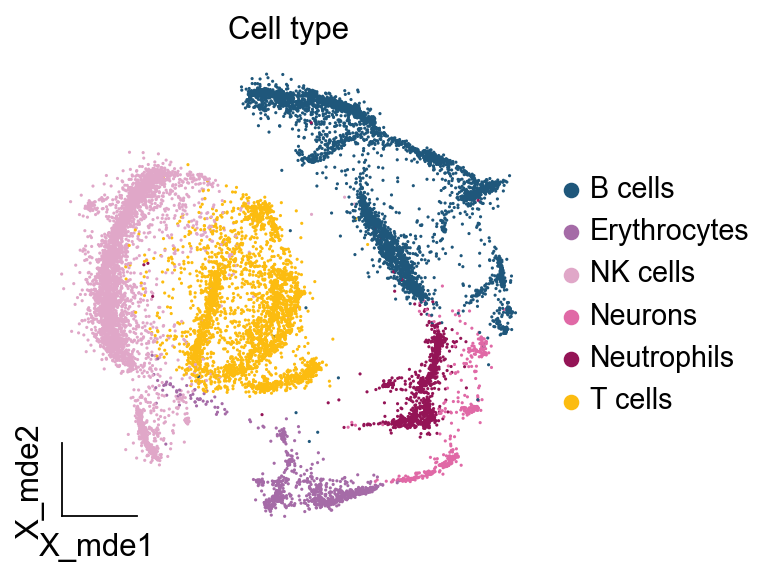

In [12]:
ov.utils.embedding(adata,
                basis='X_mde',
                color=[ "major_celltype"],
                title=['Cell type'],
                palette=ov.palette()[11:],
                show=False,frameon='small',)

## 3. CellTypist模型加载

我们首先需要下载已经训练好的模型

In [2]:
# Enabling `force_update = True` will overwrite existing (old) models.
models.download_models(force_update = True)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 31
📂 Storing models in /mnt/home/zehuazeng/.celltypist/data/models
💾 Downloading model [1/31]: Immune_All_Low.pkl
💾 Downloading model [2/31]: Immune_All_High.pkl
💾 Downloading model [3/31]: Adult_CynomolgusMacaque_Hippocampus.pkl
💾 Downloading model [4/31]: Adult_Mouse_Gut.pkl
💾 Downloading model [5/31]: Adult_Mouse_OlfactoryBulb.pkl
💾 Downloading model [6/31]: Adult_Pig_Hippocampus.pkl
💾 Downloading model [7/31]: Adult_RhesusMacaque_Hippocampus.pkl
💾 Downloading model [8/31]: Autopsy_COVID19_Lung.pkl
💾 Downloading model [9/31]: COVID19_HumanChallenge_Blood.pkl
💾 Downloading model [10/31]: COVID19_Immune_Landscape.pkl
💾 Downloading model [11/31]: Cells_Fetal_Lung.pkl
💾 Downloading model [12/31]: Cells_Intestinal_Tract.pkl
💾 Downloading model [13/31]: Cells_Lung_Airway.pkl
💾 Downloading model [14/31]: Developing_Human_Brain.pkl
💾 Downloading model [15/31]: Developing_Human_

所有的模型被存放在`models.models_path`

In [4]:
models.models_path

'/mnt/home/zehuazeng/.celltypist/data/models'

我们可以使用`models.models_description`获取更加详细的信息

In [6]:
models.models_description().head()

👉 Detailed model information can be found at `https://www.celltypist.org/models`


,model,description
0,Immune_All_Low.pkl,immune sub-populations combined from 20 tissue...
1,Immune_All_High.pkl,immune populations combined from 20 tissues of...
2,Adult_CynomolgusMacaque_Hippocampus.pkl,cell types from the hippocampus of adult cynom...
3,Adult_Mouse_Gut.pkl,cell types in the adult mouse gut combined fro...
4,Adult_Mouse_OlfactoryBulb.pkl,cell types from the olfactory bulb of adult mice


选择您要使用的模型，例如，包含低层次（高分辨率）免疫细胞类型/亚型的所有组织组合模型。

In [7]:
# Indeed, the `model` argument defaults to `Immune_All_Low.pkl`.
model = models.Model.load(model = 'Immune_All_Low.pkl')

In [8]:
model

CellTypist model with 98 cell types and 6639 features
    date: 2022-07-16 00:20:42.927778
    details: immune sub-populations combined from 20 tissues of 18 studies
    source: https://doi.org/10.1126/science.abl5197
    version: v2
    cell types: Age-associated B cells, Alveolar macrophages, ..., pDC precursor
    features: A1BG, A2M, ..., ZYX

## 4. CellTypist注释

我们使用`celltypist.annotate`中的默认模式()将细胞类型标签从模型传输到查询数据集。启用此模式后，每个查询单元格都会被预测为模型中所有可能的单元格类型中得分/概率最大的单元格类型。mode = 'best match'

In [41]:
# Not run; predict cell identities using this loaded model.
#predictions = celltypist.annotate(adata_500, model = model, majority_voting = True, mode = 'best match')
# Alternatively, just specify the model name (recommended as this ensures the model is intact every time it is loaded).
# `p_thres` defaults to 0.5.
predictions = celltypist.annotate(adata, model = 'Immune_All_Low.pkl', majority_voting = True, mode = 'prob match', p_thres = 0.5)


🔬 Input data has 14814 cells and 20171 genes
🔗 Matching reference genes in the model
🧬 5295 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10


running Leiden clustering
    finished: found 111 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:01)


🗳️ Majority voting the predictions
✅ Majority voting done!


默认情况下（majority_voting = False），CellTypist 会独立推断出每个查询单元格的身份。这会产生原始的预测单元格类型标签，通常会在几秒或几分钟内完成，具体取决于查询数据的大小。你也可以打开多数票分类器（majority_voting = True），它可以在过度聚类方法之后，以增加运行时间为代价，在本地子聚类中完善细胞身份。

结果包括预测的细胞类型标签（predicted_labels）、过度聚类结果（over_clustering）和本地子聚类中多数投票后的预测标签（majority_voting）。请注意，在预测标签中，每个查询单元格都是通过从给定模型中所有可能的单元格类型中选择最可能的单元格类型来获得推断标签的。

In [42]:
adata_new = predictions.to_adata()
adata_new

AnnData object with n_obs × n_vars = 14814 × 20171
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class', 'leiden_res1', 'major_celltype', 'manual_celltype', 'minor_celltype', 'predicted_labels', 'majority_voting', 'conf_score', 'over_clustering'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'mean', 'var', 'highly_variable_features'
    uns: 'hvg', 'layers_counts', 'leiden', 'leiden_res1_colors', 'log1p', 'major_celltype_colors',

... storing 'mean' as categorical
... storing 'var' as categorical
... storing 'mean' as categorical
... storing 'var' as categorical


[<AxesSubplot: title={'center': 'major_celltype'}, xlabel='X_mde1', ylabel='X_mde2'>,
 <AxesSubplot: title={'center': 'majority_voting'}, xlabel='X_mde1', ylabel='X_mde2'>]

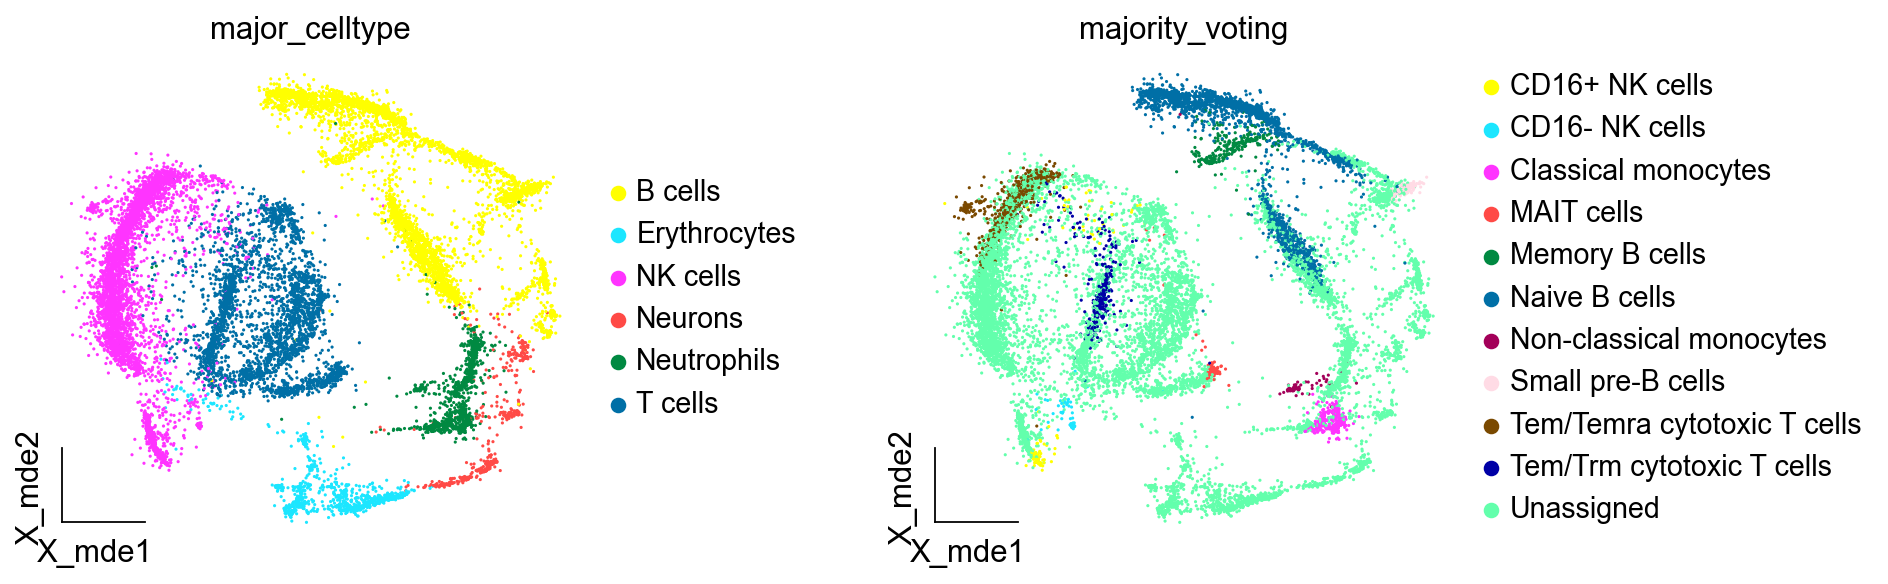

In [43]:
ov.utils.embedding(adata_new,
                basis='X_mde',
                color=[ "major_celltype","majority_voting"],
                #title=['Cell type'],
                palette=sc.pl.palettes.default_102,
                show=False,frameon='small',wspace=0.45)

我们观察后发现，大部分细胞类型被标注为Unassigned，这是由于我们设定了预测概率0.5作为阈值，低于该阈值的细胞不被注释，表明Celltypist在注释复杂的未知的数据上的效果，并不如手动注释或者是SCSA。

而如果我们想看到每一类细胞被注释的概率，我们可以设定参数`insert_prob=True`

In [44]:
adata_new= predictions.to_adata(insert_prob = True)

... storing 'mean' as categorical
... storing 'var' as categorical
... storing 'mean' as categorical
... storing 'var' as categorical


[<AxesSubplot: title={'center': 'Naive B cells'}, xlabel='X_mde1', ylabel='X_mde2'>,
 <AxesSubplot: title={'center': 'Tem/Trm cytotoxic T cells'}, xlabel='X_mde1', ylabel='X_mde2'>]

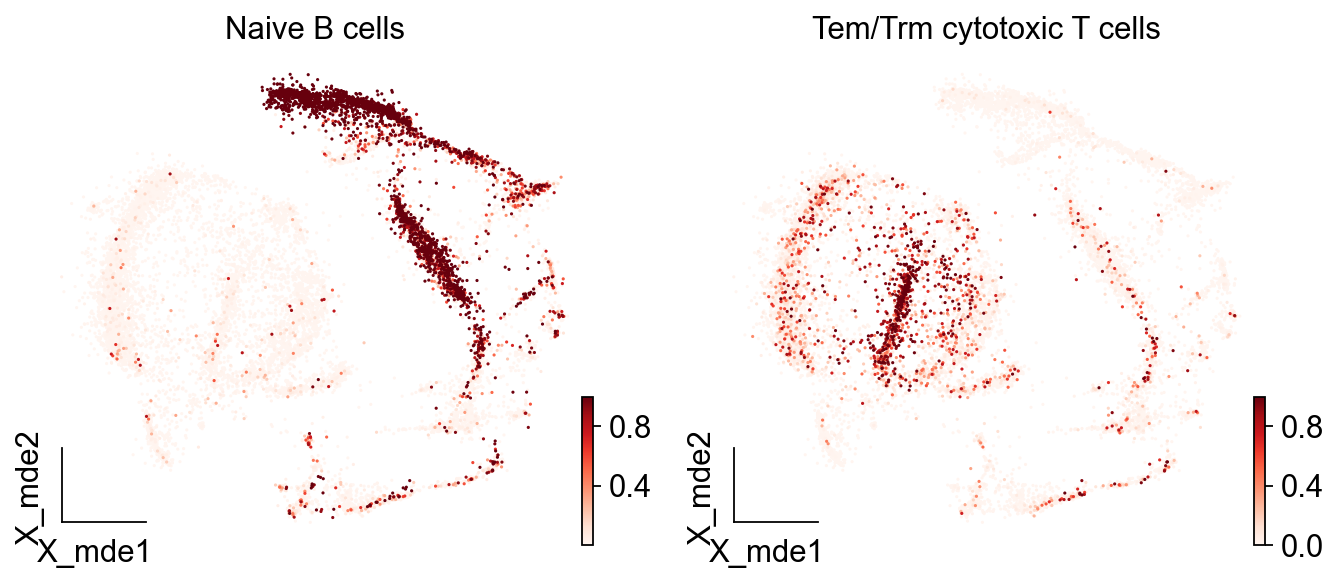

In [46]:
ov.utils.embedding(adata_new,
                basis='X_mde',
                color=[ "Naive B cells","Tem/Trm cytotoxic T cells"],
                #title=['Cell type'],
                palette=sc.pl.palettes.default_102,
                cmap='Reds',
                show=False,frameon='small')

实际上，您可能并不需要明确地将 celltypist.annotate 输出的预测结果转换成上述的 AnnData。更有用的方法是使用可视化函数 celltypist.dotplot，将 CellTypist 预测结果（例如这里的 majority_voting）与 AnnData 中预定义的单元格类型（这里的 cell_type）进行定量比较。您也可以将 use_as_prediction 的值改为 predicted_labels，将原始预测结果与预定义的细胞类型进行比较。

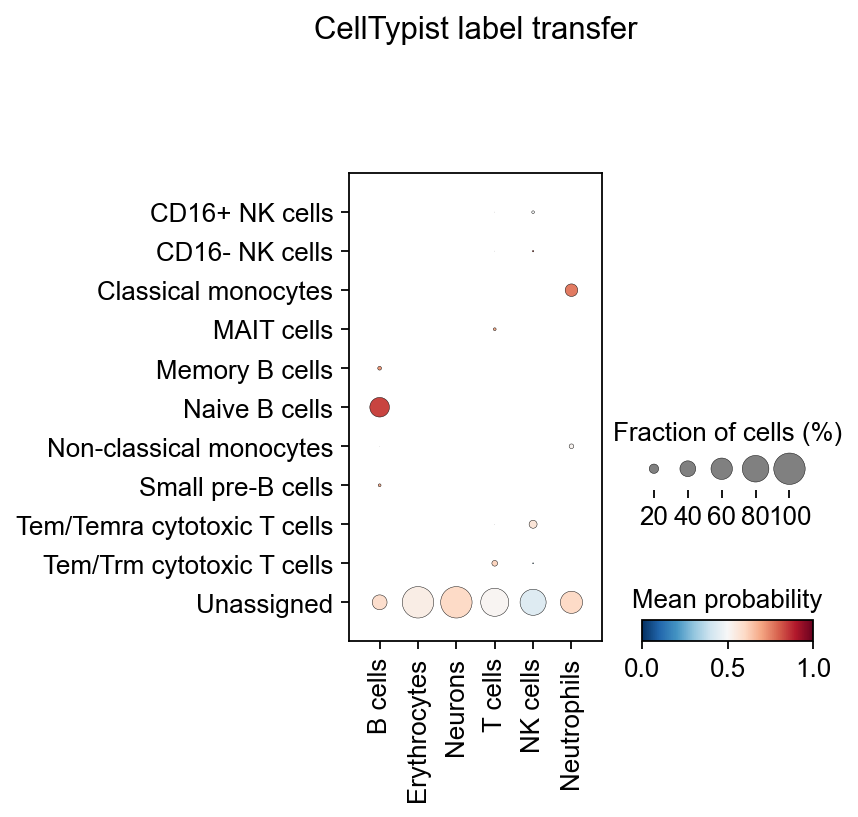

In [47]:
celltypist.dotplot(predictions, use_as_reference = 'major_celltype', use_as_prediction = 'majority_voting')

在髓系数据集上注释失败并不意味着该算法不好，而是说明对于没有典型marker的细胞类型来说，例如表达MS4A1相对一般的B细胞，我们大部分自动注释算法都会表现地比较差，这时候，手动注释相对会更可靠一些。

## 5. 泛癌细胞类型自动注释

MetaTiME 通过整合数百个肿瘤 scRNA-seq 数据中的数百万个单细胞，学习数据驱动、可解释和可重复的基因程序。我们的想法是从大规模数据中学习具有生物意义的单细胞空间图，这有助于理解功能性细胞状态，并将知识转移到新的数据分析中。MetaTiME 提供经过预训练的元组件（MeCs），可自动注释细粒度细胞状态，并绘制肿瘤微环境新单细胞的特征连续图。

我们首先加载一个已经注释好的乳腺癌淋巴结的单细胞测序数据，我们所加载的数据都是已经注释好的，为了方便我们比较注释的效果

In [68]:
adata=ov.utils.read('/mnt/home/zehuazeng/analysis/brca/data/analysis_lymph/lymph_anno.h5ad')
adata

AnnData object with n_obs × n_vars = 55571 × 3000
    obs: 'sample_path', 'lymph_sample', 'lymph_sample_rep', 'GSM', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', '_scvi_batch', '_scvi_labels', 'leiden', 'scsa_celltype', 'major_celltype'
    var: 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'lymph_sample_colors', 'major_celltype_colors', 'neighbors', 'pearson_residuals_normalization', 'rank_genes_groups', 'scrublet', 'scsa_celltype_colors'
    obsm: 'X_mde', 'X_scVI'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

<AxesSubplot: title={'center': 'Cell type'}, xlabel='X_mde1', ylabel='X_mde2'>

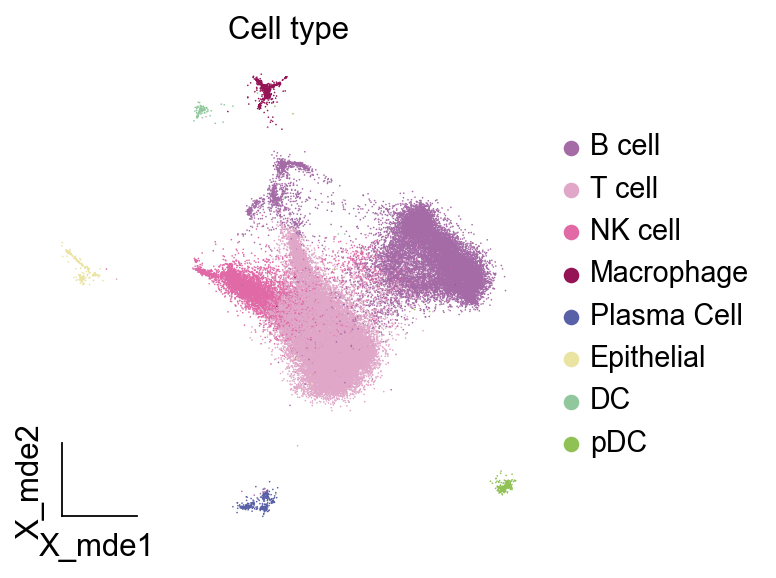

In [69]:
ov.utils.embedding(adata,
                basis='X_mde',
                color=[ "major_celltype"],
                title=['Cell type'],
                #palette=sc.pl.palettes.default_102,
                cmap='Reds',
                show=False,frameon='small')

接下来，让我们加载预先计算好的 MetaTiME 元模型（MeCs）及其功能注释。

In [70]:
TiME_object=ov.single.MetaTiME(adata,mode='table')

metatime have been install version: 1.3.0
...load pre-trained MeCs
...load functional annotation for MetaTiME-TME


我们可以对细胞进行过度聚类，这对细粒度的细胞状态注释非常有用。

随着分辨率的提高，聚类的数量也会增加，为了尽最大可能地增加注释精度，我们将resolution设置为8

In [71]:
TiME_object.overcluster(resolution=8,clustercol = 'overcluster',)

...overclustering using leiden
running Leiden clustering
    finished: found 294 clusters and added
    'overcluster', the cluster labels (adata.obs, categorical) (0:00:24)


我们使用 TiME_object.predictTiME()来预测 TME 中的潜在细胞类型。

- 细胞亚群将存储在 adata.obs['MetaTiME'] 中。
- 细胞类型将存储在 adata.obs['Major_MetaTiME'] 中。

In [72]:
TiME_object.predictTiME(save_obs_name='MetaTiME')

...projecting MeC scores
......The predicted celltype have been saved in obs.MetaTiME
......The predicted major celltype have been saved in obs.Major_MetaTiME


AnnData object with n_obs × n_vars = 55571 × 3000
    obs: 'sample_path', 'lymph_sample', 'lymph_sample_rep', 'GSM', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', '_scvi_batch', '_scvi_labels', 'leiden', 'scsa_celltype', 'major_celltype', 'overcluster', 'MetaTiME_overcluster', 'MetaTiME', 'Major_MetaTiME'
    var: 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'lymph_sample_colors', 'major_celltype_colors', 'neighbors', 'pearson_residuals_normalization', 'rank_genes_groups', 'scrublet', 'scsa_celltype_colors'
    obsm: 'X_mde', 'X_scVI'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

对比手动注释与自动注释的结果，我们可以发现MetaTiME的注释准确率相当地高，其从百万泛癌图谱训练出来也正意味着其具有着较强的泛化能力

[<AxesSubplot: title={'center': 'Major_MetaTiME'}, xlabel='X_mde1', ylabel='X_mde2'>,
 <AxesSubplot: title={'center': 'major_celltype'}, xlabel='X_mde1', ylabel='X_mde2'>]

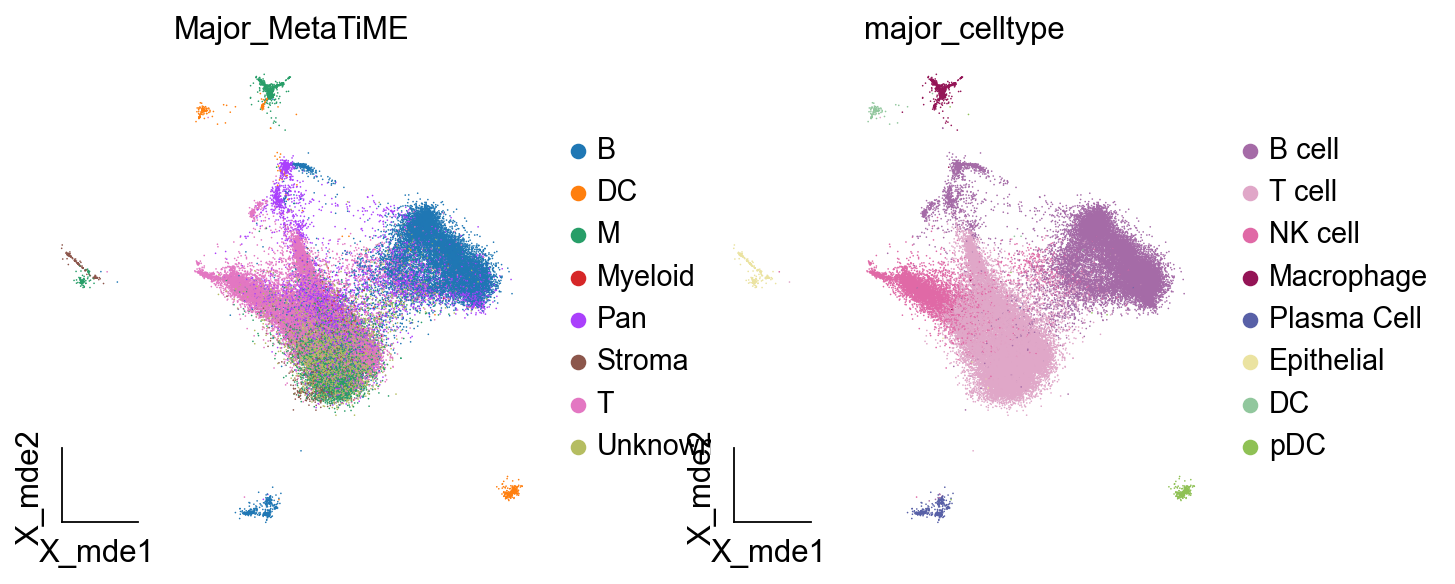

In [78]:
ov.utils.embedding(adata,
                  basis='X_mde',
                  color=['Major_MetaTiME','major_celltype'],
                   show=False, add_outline=False, 
                   frameon='small',legend_fontoutline=2,
                 )

由于细胞亚群较多，常规的可视化方法可能会出现标签遮挡，我们这里提供了两个函数来避免这一情况的出现

1. 你可以使用`TiME_object.plot`来可视化
2. 你也可以使用`ov.utils.gen_mpl_labels`来优化重叠标签

... storing 'MetaTiME_overcluster' as categorical
... storing 'MetaTiME' as categorical
... storing 'Major_MetaTiME' as categorical


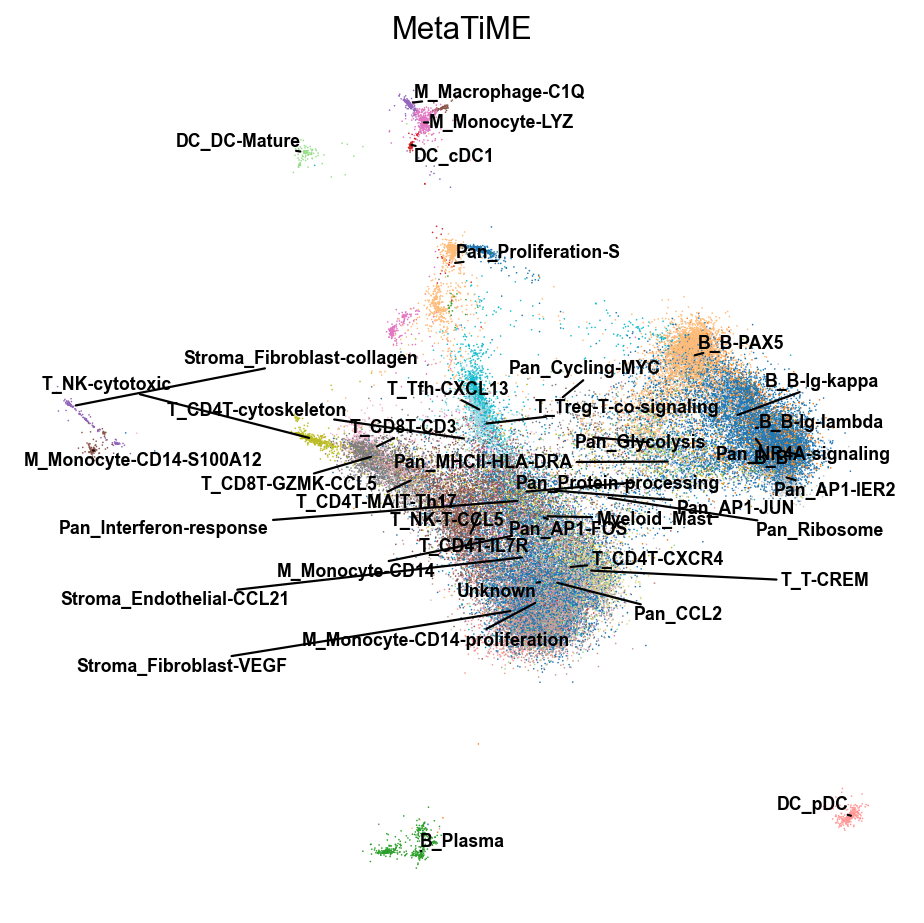

In [73]:
fig,ax=TiME_object.plot(cluster_key='MetaTiME',basis='X_mde',dpi=80)
#fig.save

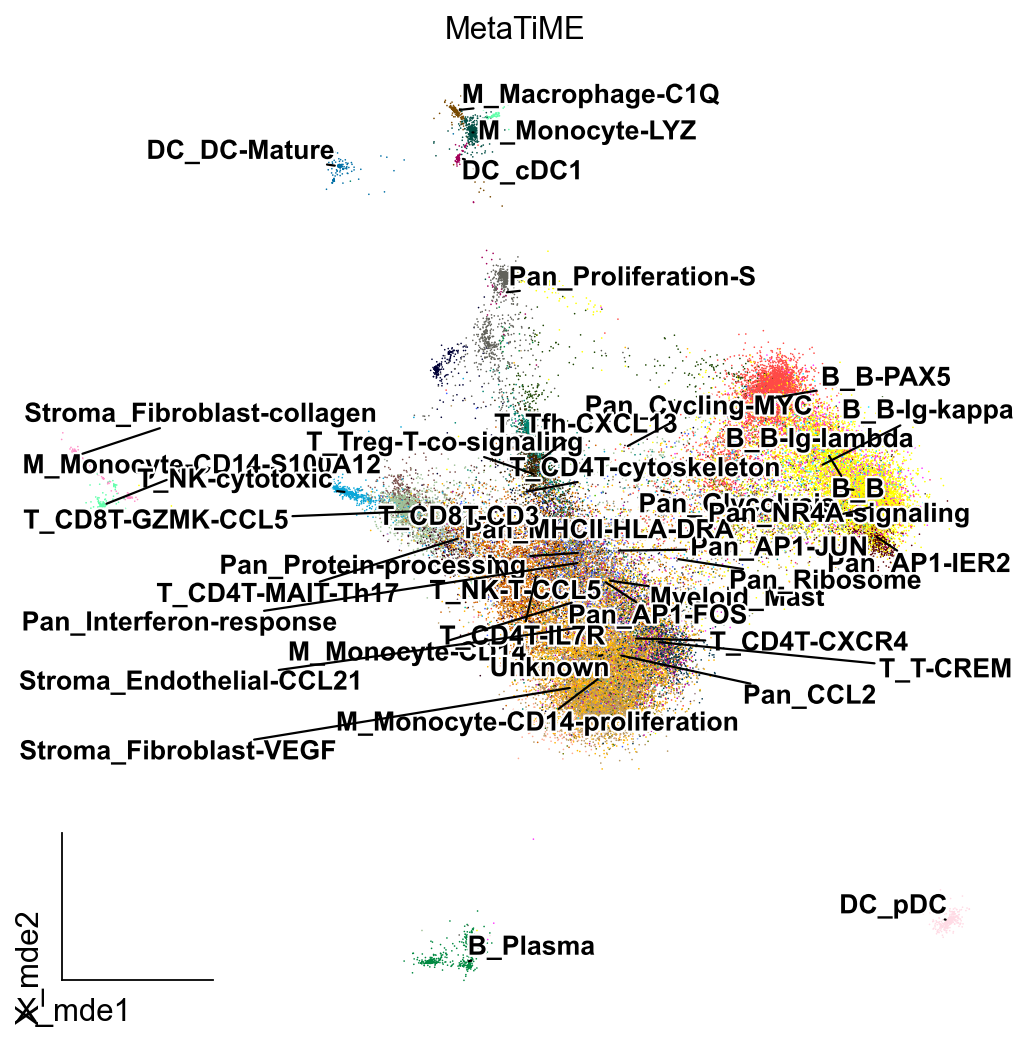

In [80]:
from matplotlib import patheffects
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,8))
ov.utils.embedding(adata,
                  basis='X_mde',
                  color=['MetaTiME'],
                   show=False, legend_loc=None, add_outline=False, 
                   frameon='small',legend_fontoutline=2,ax=ax
                 )

ov.utils.gen_mpl_labels(
    adata,
    'MetaTiME',
    exclude=("None",),  
    basis='X_mde',
    ax=ax,
    adjust_kwargs=dict(arrowprops=dict(arrowstyle='-', color='black')),
    text_kwargs=dict(fontsize= 12 ,weight='bold',
                     path_effects=[patheffects.withStroke(linewidth=2, foreground='w')] ),
)

以上便是自动注释的全部内容了，事实上，自动注释的准确率完全取决于训练数据的规模以及数据集的匹配程度，在复杂的单细胞测序数据，以及稀有组织中，其注释能力往往较差，这时候我们就需要用手动注释的方式寻找簇的marker来完成细胞类型的注释。